In [32]:
import pandas as pd
event_data = pd.read_csv('event_data_train.csv')
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')
event_data['day'] = event_data.date.dt.date
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


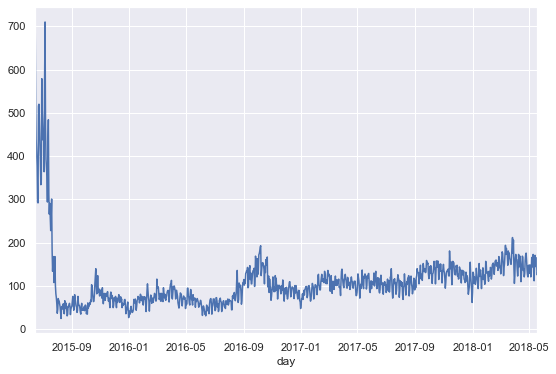

In [33]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize': (9,6)})
event_data.groupby('day').user_id.nunique().plot()

In [34]:
threshold = 2 * 24 * 60 * 60
event_data_train = event_data.merge(event_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'})
                                   .rename(columns={'timestamp': 'first_timestamp'}))
event_data_train['last_timestamp'] = event_data_train.first_timestamp + threshold
event_data_train = event_data_train[event_data_train.timestamp < event_data_train.last_timestamp]
event_data_train.groupby('user_id')['day'].nunique().max()

3

In [35]:
x = event_data_train.pivot_table(index='user_id'
                           , columns='action'
                           , values='step_id'
                           , aggfunc='count'
                           , fill_value=0).reset_index()
x.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [36]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [37]:
submissions_data_train = submissions_data.merge(submissions_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'})
                                   .rename(columns={'timestamp': 'first_timestamp'}))
submissions_data_train['last_timestamp'] = submissions_data_train.first_timestamp + threshold
submissions_data_train = submissions_data_train[submissions_data_train.timestamp < submissions_data_train.last_timestamp]
submissions_data_train.groupby('user_id')['day'].nunique().max()

3

In [38]:
x = x.merge(submissions_data_train.pivot_table(index='user_id'
                                         , columns='submission_status'
                                         , values='step_id'
                                         , aggfunc='count'
                                         , fill_value=0).reset_index()
            , how='outer', on='user_id').fillna(0)
x.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,9,2.0,0.0
2,3,15,15,4,20,4.0,4.0
3,5,1,1,0,1,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [39]:
x = x.merge(submissions_data_train.groupby('user_id').step_id.nunique().to_frame()
            .reset_index().rename(columns={'step_id': 'steps_tried'}), on='user_id', how='outer').fillna(0)
x.corr()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,steps_tried
user_id,1.000000,-0.003341,-0.004247,0.001677,-0.006513,0.002446,-0.000733,0.002661
discovered,-0.003341,1.000000,0.988623,0.884253,0.897982,0.785097,0.511716,0.791808
passed,-0.004247,0.988623,1.000000,0.900910,0.886311,0.829026,0.523472,0.832826
started_attempt,0.001677,0.884253,0.900910,1.000000,0.826955,0.836548,0.617103,0.841575
viewed,-0.006513,0.897982,0.886311,0.826955,1.000000,0.720287,0.570597,0.725012
correct,0.002446,0.785097,0.829026,0.836548,0.720287,1.000000,0.621842,0.996427
wrong,-0.000733,0.511716,0.523472,0.617103,0.570597,0.621842,1.000000,0.634379
steps_tried,0.002661,0.791808,0.832826,0.841575,0.725012,0.996427,0.634379,1.000000


In [40]:
temp = (event_data_train.groupby('user_id').timestamp.max() - event_data_train.groupby('user_id').first_timestamp.max())\
    .to_frame().reset_index().rename(columns={0:'timestamp_diff_events'})
x = x.merge(temp, on='user_id', how='outer')
x.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,steps_tried,timestamp_diff_events
0,1,1,0,0,1,0.0,0.0,0.0,0
1,2,9,9,2,9,2.0,0.0,2.0,191
2,3,15,15,4,20,4.0,4.0,4.0,1106
3,5,1,1,0,1,2.0,2.0,2.0,0
4,7,1,1,0,1,0.0,0.0,0.0,0


In [41]:
temp = (submissions_data_train.groupby('user_id').timestamp.max() - submissions_data_train.groupby('user_id').first_timestamp.max())\
    .to_frame().reset_index().rename(columns={0:'timestamp_diff_submits'})
x = x.merge(temp, on='user_id', how='outer')
x.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,steps_tried,timestamp_diff_events,timestamp_diff_submits
0,1,1,0,0,1,0.0,0.0,0.0,0,NaN
1,2,9,9,2,9,2.0,0.0,2.0,191,65.0
2,3,15,15,4,20,4.0,4.0,4.0,1106,1040.0
3,5,1,1,0,1,2.0,2.0,2.0,0,80.0
4,7,1,1,0,1,0.0,0.0,0.0,0,NaN


In [42]:
x['efficiency'] = x.correct / x.wrong
course_length = event_data.step_id.nunique()
temp = (event_data_train.groupby('user_id').step_id.nunique() / course_length)\
    .to_frame().reset_index().rename(columns={'step_id':'event_passed_part'})
x = x.merge(temp, on='user_id', how='outer')

In [43]:
work_length = submissions_data.step_id.nunique()
temp = (submissions_data_train[submissions_data_train.submission_status == 'correct']
    .groupby('user_id').step_id.nunique() / work_length)\
    .to_frame().reset_index().rename(columns={'step_id':'submit_passed_part'})
x = x.merge(temp, on='user_id', how='outer')
x.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,steps_tried,timestamp_diff_events,timestamp_diff_submits,efficiency,event_passed_part,submit_passed_part
0,1,1,0,0,1,0.0,0.0,0.0,0,NaN,NaN,0.005051,NaN
1,2,9,9,2,9,2.0,0.0,2.0,191,65.0,inf,0.045455,0.026316
2,3,15,15,4,20,4.0,4.0,4.0,1106,1040.0,1.0,0.075758,0.052632
3,5,1,1,0,1,2.0,2.0,2.0,0,80.0,1.0,0.005051,0.026316
4,7,1,1,0,1,0.0,0.0,0.0,0,NaN,NaN,0.005051,NaN


In [61]:
import math
x = x.replace(math.inf, 0)
x = x.fillna(0)
x.head()

KeyError: "['index'] not found in axis"

In [45]:
from DataScienceCourse import stepicpreprocessing
stepicpreprocessing.make_data_ready(event_data_train, submissions_data_train).head()

,discovered,passed,started_attempt,viewed,correct,wrong,steps_tried,timestamp_diff_events,timestamp_diff_submits,efficiency,event_passed_part,submit_passed_part
0,1,0,0,1,0.0,0.0,0.0,0,0.0,0.0,0.005051,0.000000
1,9,9,2,9,2.0,0.0,2.0,191,65.0,0.0,0.045455,0.026316
2,15,15,4,20,4.0,4.0,4.0,1106,1040.0,1.0,0.075758,0.052632
3,1,1,0,1,2.0,2.0,2.0,0,80.0,1.0,0.005051,0.026316
4,1,1,0,1,0.0,0.0,0.0,0,0.0,0.0,0.005051,0.000000


In [46]:
y = event_data[event_data.action == 'passed'].groupby('user_id')\
    .step_id.nunique().to_frame().reset_index()
x.shape

(19234, 13)

In [47]:
y['passed'] = y.step_id > 40
y = y.merge(x['user_id'].to_frame(), on='user_id', how='outer').fillna(False)
y = y['passed']

In [48]:
# import numpy as np
# gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
#     .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
# gap_data = pd.Series(np.concatenate(gap_data, axis=0))
# gap_data = gap_data / (24 * 60 * 60)
# gap_data

In [49]:
# users_data['passed_course'] = users_data.passed > 170
# users_data.head()

In [50]:
# event_data['user_time'] = event_data.user_id.map(str) + '_' + event_data.timestamp.map(str)
# event_data.head()

In [51]:
# threshold = 3 * 24 * 60 * 60
# user_threshold = user_first_date.user_id.map(str) + '_' + (user_first_date.first_timestamp + threshold).map(str)
# user_threshold.head()

In [52]:
# user_first_date['user_threshold'] = user_threshold
# event_data = event_data.merge(user_first_date[['user_id', 'user_threshold']], how='outer')
# event_data.head()

In [53]:
# event_data_train = event_data[event_data.user_time <= event_data.user_threshold]
# event_data_train.head()

In [54]:
# X = X.set_index(X.user_id)
# X = X.drop('user_id', axis=1)
# X.head()

In [55]:
from sklearn.model_selection import train_test_split

x = stepicpreprocessing.make_data_ready(event_data_train, submissions_data_train)
x_train, x_eval, y_train, y_eval = train_test_split(x[['viewed', 'correct', 'wrong', 'steps_tried']], y, test_size=0.2)
x_test = stepicpreprocessing.make_data_ready(pd.read_csv('events_data_test.csv'), pd.read_csv('submission_data_test.csv'))
x_test.head()

,discovered,passed,started_attempt,viewed,correct,wrong,steps_tried,timestamp_diff_events,timestamp_diff_submits,efficiency,event_passed_part,submit_passed_part
0,1,1,0,1,0.0,0.0,0.0,0,0.0,0.000000,0.005051,0.000000
1,1,1,0,1,0.0,0.0,0.0,0,0.0,0.000000,0.005051,0.000000
2,2,2,0,6,0.0,0.0,0.0,8014,0.0,0.000000,0.010101,0.000000
3,11,9,4,14,1.0,0.0,1.0,167,0.0,0.000000,0.060606,0.013158
4,70,70,35,105,29.0,36.0,29.0,127816,127798.0,0.805556,0.353535,0.381579


In [77]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

array([[0.75763276, 0.24236724],
       [0.75763276, 0.24236724],
       [0.75763276, 0.24236724],
       ...,
       [0.75763276, 0.24236724],
       [0.75763276, 0.24236724],
       [0.75763276, 0.24236724]])

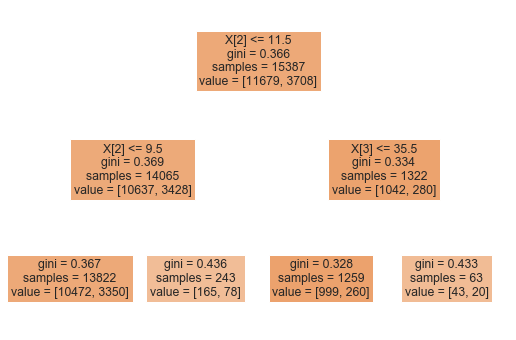

In [78]:
from sklearn.metrics import roc_auc_score
tree.plot_tree(clf, filled=True)
roc_auc_score(y_eval, clf.predict(x_eval))
clf.predict_proba(x_eval)

In [58]:
# from sklearn.model_selection import GridSearchCV
# 
# parameters = {'min_samples_leaf': range(10, 50, 10), 'max_depth': range(2, 30), 'min_samples_split': range(10, 50, 10)}
# grid_search_cv = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy'), parameters, cv=8, n_jobs=8)
# grid_search_cv.fit(x_train, y_train)
# best_clf = grid_search_cv.best_estimator_
# roc_auc_score(y_eval, best_clf.predict(x_eval))
# 

0.5

In [59]:
# grid_search_cv.best_params_

{'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 10}

In [60]:
# from sklearn.ensemble import RandomForestClassifier
# 
# parameters = {'n_estimators': range(10, 100, 10), 'max_depth': range(1, 10)}
# grid_search_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=8)
# grid_search_cv.fit(x_train, y_train)
# best_clf = grid_search_cv.best_estimator_
# roc_auc_score(y_eval, best_clf.predict(x_eval))

In [82]:
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(x_train, y_train)
roc_auc_score(y_train, clf.predict(x_train))

C:\Users\kafree\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5562489972459074